In [8]:
import os
import h5py
import numpy as np
from torchdeepretina.datas import loadexpt, _loadexpt_h5

In [9]:
data_path = os.path.join('/home/salamander/experiments/data/')

In [16]:
import torch
from collections import deque

In [13]:
def get_hs(model, batch_size, device):
    hs = []
    hs.append(torch.zeros(batch_size, *model.h_shapes[0]).to(device))
    hs[0][:,0] = 1
    hs.append(deque([],maxlen=model.seq_len))
    for i in range(model.seq_len):
        hs[1].append(torch.zeros(batch_size, *model.h_shapes[1]).to(device))
    return hs

In [4]:
hs = get_hs(model, 5)

In [21]:
from torch.utils.data.sampler import Sampler
class BatchRnnSampler(Sampler):
    
    def __init__(self, length, batch_size, seq_len):
        self.length = length
        self.batch_size = batch_size
        self.seq_len = seq_len

    def __iter__(self):
        batch_idx = 0
        count = 0
        while batch_idx < self.length // self.batch_size:
            batch = [batch_idx + n * self.__len__() for n in range(self.batch_size)]
            yield batch
            batch_idx += 1
            count += 1
            if count == self.seq_len:
                count = 0
                batch_idx -= (self.seq_len - 1)

    def __len__(self):
        return (self.length // self.batch_size - self.seq_len + 1) * self.seq_len + self.seq_len -1

In [23]:
len(BatchRnnSampler(length=30, batch_size=3, seq_len=5))

34

In [20]:
len(BatchRnnSampler(length=30, batch_size=3, seq_len=5))

10

In [23]:
data = loadexpt('15-10-07', [0,1,2,3,4], 'naturalscene', 'train', 40, 0, data_path=data_path)

In [24]:
data.X.shape

(359762, 40, 50, 50)

In [26]:
data.y.shape

(359762, 5)

In [15]:
from kinetic.data import BatchRnnSampler, TrainDataset, ValidationDataset
dataset = TrainDataset(data_path)

In [16]:
from torch.utils.data.dataloader import DataLoader
batch_sampler = BatchRnnSampler(length=len(dataset), batch_size=512, seq_len=8)
data = DataLoader(dataset=dataset, batch_sampler=batch_sampler)

In [19]:
len(batch_sampler)

644

In [8]:
for i,(x,y) in enumerate(data):
    if i == 0:
        inpt = x
        trgt = y
        break

In [9]:
inpt.shape

torch.Size([512, 40, 50, 50])

In [ ]:
dataset

In [8]:
from scipy.stats import pearsonr
device = torch.device('cuda:1')
hs = get_hs(model, 1, device)
model = model.to(device)
model.eval()
with torch.no_grad():
    pearsons = []
    val_pred = []
    val_targ = []
    for x,y in data:
        x = x.to(device)
        out, hs = model(x, hs)
        val_pred.append(out.detach().cpu().numpy().squeeze())
        val_targ.append(y.detach().numpy().squeeze())
    val_pred = np.stack(val_pred, axis=0)
    val_targ = np.stack(val_targ, axis=0)
    for cell in range(5):
        pearsons.append(pearsonr(val_pred[:,cell],val_targ[:,cell])[0])
    print(np.array(pearsons).mean())

-0.0035025242913605073


In [10]:
val_targ.shape

(30000, 5)

In [3]:
data = loadexpt('15-10-07', [0,1,2,3,4], 'naturalscene', 'train',
                40, 0, data_path=data_path)

In [18]:
X = data.X
batch_size = 512
length = X.shape[0]//batch_size
tot_len = length*batch_size
X_trunc = X[:tot_len].reshape(batch_size, length, *X.shape[1:])
X_trunc = np.transpose(X_trunc, (1,0,2,3,4))
y = data.y
batch_size = 512
length = y.shape[0]//batch_size
tot_len = length*batch_size
y_trunc = y[:tot_len].reshape(batch_size, length, *y.shape[1:])
y_trunc = np.transpose(y_trunc, (1,0,2))

In [19]:
y_trunc.shape

(702, 512, 5)

In [4]:
device = torch.device('cuda:1')

In [5]:
print(device)

cuda:1


In [4]:
import torch.nn as nn
import torch
nn.Parameter(torch.ones((5,2)).float(), requires_grad=True)

Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True)

In [2]:
import sys
sys.path.insert(0, './kinetic')
from kinetic.models import KineticsChannelModel
from kinetic.evaluation import pearsonr_eval
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import torch
device = torch.device('cuda:1')
model = KineticsChannelModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
checkpoint_path = '/home/xhding/saved_model/channel/epoch_45_loss_-3.0704265886546778_pearson_0.41805463828607137.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

In [5]:
checkpoint['model_state_dict'].pop("bipolar.2.running_mean")
checkpoint['model_state_dict'].pop("bipolar.2.running_var")
checkpoint['model_state_dict'].pop("bipolar.2.num_batches_tracked")
checkpoint['model_state_dict'].pop("amacrine.3.running_mean")
checkpoint['model_state_dict'].pop("amacrine.3.running_var")
checkpoint['model_state_dict'].pop("amacrine.3.num_batches_tracked")
checkpoint['model_state_dict'].pop("ganglion.1.running_mean")
checkpoint['model_state_dict'].pop("ganglion.1.running_var")
checkpoint['model_state_dict'].pop("ganglion.1.num_batches_tracked")
torch.save(checkpoint, '/home/xhding/saved_model/channel/epoch_46.pth')

In [3]:
model.state_dict().keys()

odict_keys(['bipolar.0.convs.0.weight', 'bipolar.0.convs.1.weight', 'bipolar.0.convs.2.weight', 'bipolar.0.convs.3.weight', 'bipolar.0.convs.4.weight', 'bipolar.0.convs.5.weight', 'bipolar.0.convs.6.weight', 'bipolar.0.convs.6.bias', 'bipolar.2.weight', 'bipolar.2.bias', 'bipolar.3.sigma', 'bipolar.6.multiplier', 'kinetics.ka', 'kinetics.kfi', 'kinetics.kfr', 'kinetics.ksi', 'kinetics.ksr', 'kinet_scale.scale_param', 'kinet_scale.shift_param', 'amacrine.1.convs.0.weight', 'amacrine.1.convs.1.weight', 'amacrine.1.convs.2.weight', 'amacrine.1.convs.3.weight', 'amacrine.1.convs.4.weight', 'amacrine.1.convs.4.bias', 'amacrine.3.weight', 'amacrine.3.bias', 'amacrine.4.sigma', 'ganglion.0.weight', 'ganglion.0.bias', 'ganglion.1.weight', 'ganglion.1.bias'])

In [6]:
checkpoint['model_state_dict'].keys()

odict_keys(['bipolar.0.convs.0.weight', 'bipolar.0.convs.1.weight', 'bipolar.0.convs.2.weight', 'bipolar.0.convs.3.weight', 'bipolar.0.convs.4.weight', 'bipolar.0.convs.5.weight', 'bipolar.0.convs.6.weight', 'bipolar.0.convs.6.bias', 'bipolar.2.weight', 'bipolar.2.bias', 'bipolar.3.sigma', 'bipolar.6.multiplier', 'kinetics.ka', 'kinetics.kfi', 'kinetics.kfr', 'kinetics.ksi', 'kinetics.ksr', 'kinet_scale.scale_param', 'kinet_scale.shift_param', 'amacrine.1.convs.0.weight', 'amacrine.1.convs.1.weight', 'amacrine.1.convs.2.weight', 'amacrine.1.convs.3.weight', 'amacrine.1.convs.4.weight', 'amacrine.1.convs.4.bias', 'amacrine.3.weight', 'amacrine.3.bias', 'amacrine.4.sigma', 'ganglion.0.weight', 'ganglion.0.bias', 'ganglion.1.weight', 'ganglion.1.bias'])

In [7]:
class ValidationDataset(Dataset):
    
    def __init__(self, data_path):
        super().__init__()
        data = loadexpt('15-10-07', [0,1,2,3,4], 'naturalscene', 'train',
                        40, 0, data_path=data_path)
        val_size = 30000
        self.X = data.X[-val_size:]
        self.y = data.y[-val_size:]
        self.centers = data.centers
        self.stats = data.stats
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        inpt = torch.from_numpy(self.X[index])
        trgt = torch.from_numpy(self.y[index])
        return (inpt, trgt)
    

In [13]:
validation_data =  DataLoader(ValidationDataset(data_path))
pearson = pearsonr_eval(model, validation_data, 5, device)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 10368])

In [18]:
pearson

0.3579518903352822

In [3]:
from kinetic.data import BatchRnnSampler
list(BatchRnnSampler(500, 50, 8))

[[0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250,
  260,
  270,
  280,
  290,
  300,
  310,
  320,
  330,
  340,
  350,
  360,
  370,
  380,
  390,
  400,
  410,
  420,
  430,
  440,
  450,
  460,
  470,
  480,
  490],
 [1,
  11,
  21,
  31,
  41,
  51,
  61,
  71,
  81,
  91,
  101,
  111,
  121,
  131,
  141,
  151,
  161,
  171,
  181,
  191,
  201,
  211,
  221,
  231,
  241,
  251,
  261,
  271,
  281,
  291,
  301,
  311,
  321,
  331,
  341,
  351,
  361,
  371,
  381,
  391,
  401,
  411,
  421,
  431,
  441,
  451,
  461,
  471,
  481,
  491],
 [2,
  12,
  22,
  32,
  42,
  52,
  62,
  72,
  82,
  92,
  102,
  112,
  122,
  132,
  142,
  152,
  162,
  172,
  182,
  192,
  202,
  212,
  222,
  232,
  242,
  252,
  262,
  272,
  282,
  292,
  302,
  312,
  322,
  332,
  342,
  352,
  362,
  372,
  382,
  392,
  402,
  412,
  422,
  432,
  442,
  452,
  462,
  

In [3]:
import matplotlib.pyplot as plt
import numpy as np

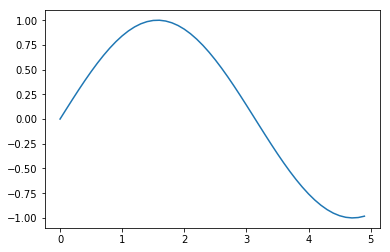

In [6]:
x = np.arange(0, 5, 0.1)
y = np.sin(x)
plt.plot(x, y)
plt.show()

In [36]:
import sys
sys.path.insert(0, './kinetic')
from kinetic.models import KineticsChannelModel
from kinetic.evaluation import pearsonr_eval
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import torch
device = torch.device('cuda:0')
model = KineticsChannelModel().to(device)
#checkpoint_path = '/home/xhding/saved_model/channel2/epoch_005_loss_-3.28_pearson_-0.0079.pth'
checkpoint_path = '/home/xhding/saved_model/channel/epoch_45_loss_-3.0704265886546778_pearson_0.41805463828607137.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [37]:
class ValidationDataset(Dataset):
    
    def __init__(self, data_path):
        super().__init__()
        data = loadexpt('15-10-07', [0,1,2,3,4], 'naturalscene', 'train',
                        40, 0, data_path=data_path)
        val_size = 30000
        self.X = data.X[0:val_size]
        self.y = data.y[0:val_size]
        self.centers = data.centers
        self.stats = data.stats
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        inpt = torch.from_numpy(self.X[index])
        trgt = torch.from_numpy(self.y[index])
        return (inpt, trgt)
validation_data =  DataLoader(ValidationDataset(data_path))

In [39]:
def pearsonr_eval(model, data, n_units, device):
    hs = get_hs(model, 1, device)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        pearsons = []
        val_pred = []
        val_targ = []
        for x,y in data:
            x = x.to(device)
            out, hs = model(x, hs)
            val_pred.append(out.detach().cpu().numpy().squeeze())
            val_targ.append(y.detach().numpy().squeeze())
        val_pred = np.stack(val_pred, axis=0)
        val_targ = np.stack(val_targ, axis=0)
        for cell in range(n_units):
            pearsons.append(pearsonr(val_pred[:,cell],val_targ[:,cell])[0])
        model.train()
        return np.array(pearsons).mean(), val_pred, val_targ

In [40]:
from scipy.stats import pearsonr
pc, pred, targ = pearsonr_eval(model, validation_data, 5, device)

In [41]:
pc

0.4108218647685084

In [42]:
pred[21000:21100,3]

array([0.40893975, 0.40948418, 0.41150495, 0.41919985, 0.42313787,
       0.43426737, 0.47184646, 0.5339878 , 0.6174099 , 0.7082607 ,
       0.79325217, 0.87827164, 0.9389497 , 0.9642763 , 0.9274244 ,
       0.86866426, 0.833767  , 0.79222906, 0.7820203 , 0.8028346 ,
       0.92672175, 1.2202032 , 1.5744325 , 1.79328   , 1.8598652 ,
       1.7252023 , 1.3742914 , 0.8799336 , 0.5546501 , 0.51331186,
       0.850829  , 1.8693075 , 3.5356889 , 5.5804615 , 7.7717314 ,
       9.423938  , 9.440884  , 8.002787  , 6.2089586 , 4.394852  ,
       3.0475838 , 2.0387793 , 1.3239295 , 0.92205596, 0.6628606 ,
       0.46340144, 0.39761263, 0.35650983, 0.36034703, 0.41376388,
       0.47783035, 0.5017842 , 0.46015722, 0.41990554, 0.4048472 ,
       0.4015095 , 0.40133572, 0.41616258, 0.46790478, 0.564943  ,
       0.6877945 , 0.7986342 , 0.8963872 , 0.9863641 , 1.0480021 ,
       1.0761828 , 1.1376846 , 1.2883202 , 1.533076  , 1.8364303 ,
       2.1991477 , 2.6149654 , 3.025171  , 3.3071122 , 3.39866

In [43]:
targ[21000:21100,3]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.48672163e-04, 1.34345990e-02,
       4.45748442e-01, 5.43031516e+00, 2.42901565e+01, 3.98938240e+01,
       2.40575334e+01, 5.32680261e+00, 4.33064104e-01, 1.29273006e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [44]:
def eval_loss(pred, targ, device):
    batch_size = 512
    loss_fn = nn.PoissonNLLLoss(log_input=False, reduction='sum').to(device)
    loss = 0
    n_batch = pred.shape[0] // batch_size
    pred = torch.from_numpy(pred)
    targ = torch.from_numpy(targ)
    with torch.no_grad():
        for idx in range(n_batch):
            loss += loss_fn(pred[batch_size*idx:batch_size*(idx+1)].to(device), 
                            targ[batch_size*idx:batch_size*(idx+1)].to(device))
    loss /= pred.shape[0]
    return loss

In [45]:
import torch.nn as nn
eval_loss(pred, targ, device)

tensor(-10.3883, device='cuda:0', dtype=torch.float64)

In [33]:
pred.shape

(30000, 5)